# Datenbearbeitung und Datenstandardisierung

Maja Lichman

## Contents
1. [Daten](#1.-Daten)
2. [Ermittlung der Berufsgruppe Politik](#2.-Ermittlung-der-Berufsgruppe-Politik)
3. [Standardisierung der Namen](#3.-Standardisierung-der-Namen)
4. [Ermittlung des Geschlechts](#4.-Ermittlung-des-Geschlechts)
5. [Ermittlung des Geburtsjahres und Sterbejahres](#5.-Ermittlung-des-Geburtsjahres-und-Sterbejahres)
6. [Ermittlung des Ausreisealters](#6.-Ermittlung-des-Ausreisealters)
7. [Ermittlung der Anzahl der Zielorte](#7.-Ermittlung-der-Anzahl-der-Zielorte)
8. [Standardisierung der Länder](#8.-Standardisierung-der-Länder)

In [3]:
import pandas as pd
from IPython.display import HTML
from IPython.core.display import HTML
from IPython.display import Image
import re
import gender_guesser.detector as gender
import matplotlib.pyplot as plt
import requests
import geonamescache
from geonamescache import GeonamesCache 
import numpy as np
import plotly.express as px
from translate import Translator 
from geopy.geocoders import Nominatim
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

## 1. Daten

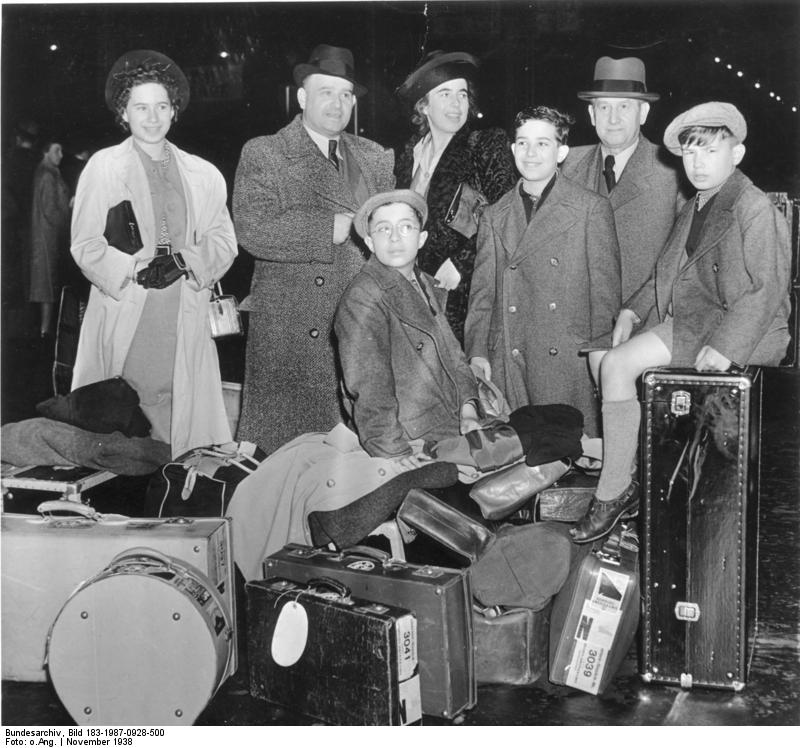

In [5]:
display(Image(filename='Bild.jpg', width=600, height=500))

**Bildquelle**: Von Bundesarchiv, Bild 183-1987-0928-500 / CC-BY-SA 3.0, <a href="https://creativecommons.org/licenses/by-sa/3.0/de/deed.en" title="Creative Commons Attribution-Share Alike 3.0 de">CC BY-SA 3.0 de</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=5424100">Link</a>

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 30px; line-height: 1.8;">Die Daten, die mir für dieses Projekt zur Verfügung standen, wurden von der ehemaligen Studentin der <i>Universität Stuttgart</i> <b>Stephanie Bujak</b> erstellt. Als Datengrundlage diente ihr das <i>Biographisches Handbuch der deutschsprachigen Emigration nach 1933</i>, herausgegeben 1980/83 von <b>Werner Röder</b> und <b>Herbert Strauss</b>. Die Studentin hat die Einträge des digitalen Handbuchs mithilfe der Python-Skripte in eine Excel-Tabelle extrahiert. Die Tabelle enthält damit personen- und ausreisebezogene Informationen zu 7.871 Personen, die nach der Machtergreifung der Nationalsozialisten aus Deutschland, Österreich und der deutschsprachigen Tschechoslowakei ausgewandert sind. Die Tabelle bildet momentan die Grundlage der digitalen <a href="https://www.hi.uni-stuttgart.de/gnt/exil/Personen.html" target="_blank"><b>Datenbank</b></a> auf der <a href="https://www.hi.uni-stuttgart.de/gnt/exil/index.html" target="_blank"><b>Webseite</b></a> <i>Emigration und Exil von Wissenschaftlern und Ingenieuren 1930-1950</i>. Die Daten in der Tabelle sind aber nicht standardisiert und aus diesem Grund für statistische Untersuchungen kaum geeignet. In diesem Projekt wird der Standardisierungsprozess dieser Daten gezeigt. Anschließend werden die standardisierten Daten mit <b>bar_plots</b>, <b>bar_polar</b> und <b>heatmap</b> visualisiert.</div>  

In [10]:
df_alt = pd.read_excel("Tabelle.xlsx") # Tabelle in Python offnen

In [11]:
df_alt.shape # Anzahl Zeilen und Spalten

(7871, 32)

In [12]:
colnames = df_alt.columns.tolist()
print(colnames) # Spaltennamen

['PersonID', 'Name', 'Geburtsdatum,-ort/ggf. Sterbedatum,-ort', 'Beruf', 'Zieljahr1', 'Zielort1', 'Zieljahr2', 'Zielort2', 'Zieljahr3', 'Zielort3', 'Zieljahr4', 'Zielort4', 'Zieljahr5', 'Zielort5', 'Zieljahr6', 'Zielort6', 'Zieljahr7', 'Zielort7', 'Zieljahr8', 'Zielort8', 'Zieljahr9', 'Zielort9', 'Zieljahr10', 'Zielort10', 'Zieljahr11', 'Zielort11', 'Zieljahr12', 'Zielort12', 'Zieljahr13', 'Zielort13', 'Zieljahr14', 'Zielort14']


In [13]:
HTML(df_alt.iloc[:10, :4].to_html(index=False))

PersonID,Name,"Geburtsdatum,-ort/ggf. Sterbedatum,-ort",Beruf
1,"Abel, August","geb. 19. Dez. 1887 Gelsenkirchen, gest. 18. Aug. 1962 Frankfurt/M.;",Journalist
2,"Abel, Emil","b. Vienna 2 June 1875, d. London 3 Apr. 1958.",prof. of chemistry
3,"Abel, Paul, Dr. jur.","geb. 21. März 1874 Wien, gest. 10. Mai 1971 London;",Rechtsanwalt
4,"Abeles, Paul William",b. Mistelbach near Vienna 17 Jan. 1897.,civil engineer
5,"Abeles, Robert Heinz",b. Vienna 14 Jan. 1926.,prof. of biochemistry
6,"Abelmann, Walter H",b. Frankfurt/M 16 May 1921.,prof. of medicine
7,"Aber, Adolf","b. Apolda, Thuringia, Ger. 28 Jan. 1893, d. London 21 May 1960.",musicologist
8,"Aber, Felix, Dr. phil.","geb. 11. Apr. 1895 Breslau, gest. 14. Jan. 1964 New York;",Rabbiner
9,"Abraham, Claude Kurt (fmly. Kurt Jakob Abraham)","b. Lorsch, Hessen, Ger. 13 Dec. 1931.",prof. of French
10,"Abraham, Heinz, Dr.",geb. 30. Juni 1911 Allenstein/Ostpr.;,"Diplomat, Historiker"


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Die Spalten <b>[1]</b> bis <b>[3]</b> enthalten folgende Daten: 
    <ul>
        <li><b>Name:</b> Nachnamen und Vornamen in einer Spalte, oft mit Zusatzinfo in Klammern oder nach Komma</li>
        <li><b>Geburtsdatum,-ort/ggf. Sterbedatum,-ort:</b> Angaben zu Geburtsort und Geburtsdatum sowie ggf. zu Sterbeort und Sterbedatum in einer Spalte. Manche Eintrage auf Deutsch, manche auf Englisch </li>
        <li><b>Beruf:</b> die Spalte ist ebenfalls zweisprachig, enthält Angaben zu Beruf der Personen, manchmal kommen Mehrfachnennungen vor</li>
    </ul>
</div>


In [15]:
HTML(df_alt.iloc[:10, 4:19].to_html(index=False))

Zieljahr1,Zielort1,Zieljahr2,Zielort2,Zieljahr3,Zielort3,Zieljahr4,Zielort4,Zieljahr5,Zielort5,Zieljahr6,Zielort6,Zieljahr7,Zielort7,Zieljahr8
1934.0,Afrika,1948.0,Deutschland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938.0,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938.0,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939.0,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939.0,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1933.0,Switzerland,1939.0,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1933.0,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1939.0,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938.0,France,1946.0,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1933.0,Moskau,1937.0,Spain,1939.0,France,NaN,Moskau,NaN,Deutschland,NaN,NaN,NaN,NaN,NaN


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Die Spalten <b>[4]</b> bis <b>[32]</b> enthalten emigrationsbezogene Daten:
    <ul>
        <li><b>Zieljahr1</b> bis <b>Zieljahr14</b>: Angaben zu Ausreisejahren, bereits standardisiert.
 Die Spalte <b>Zieljahr1</b> gibt den Jahr der ersten Ausreise aus dem deutschsprachigen Land an. Die weiteren Spalten sind mit Werten besetzt, falls eine Person während der Emigrationsperiode mehrmals die Zielländer gewechselt hat</li>
       <li><b>Zielort1 bis Zielort14</b>: Angabe zu einem oder mehreren Zielorten. Nicht standardisiert. Enthält Einträge aud Englisch und Deutsch,
Abkürzungen der Ländernamen wie z. B. USA oder UK. Manchmal stehen in der Spalte auch nicht Länder sondern Städte</li>
    </ul>
</div>

## 2. Ermittlung der Berufsgruppe Politik

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-bottom: 20px; line-height: 1.8;">In diesem Projekt wird für die Standardisierung, Bearbeitung und nachfolgende Visualisierung beispielhaft die Berufsgruppe <b>Politik</b>
gewählt.   
Die Personen, die als Politiker tätig waren, wurden mit Buchstabenstrings gesucht.</div>

In [19]:
Beruf = df_alt["Beruf"].tolist() # Spalte Beruf als Liste

In [20]:
df_alt['Beruf'].head(20).to_list()

['Journalist',
 'prof. of chemistry',
 'Rechtsanwalt',
 'civil engineer',
 'prof. of biochemistry',
 'prof. of medicine',
 'musicologist',
 'Rabbiner',
 'prof. of French',
 'Diplomat,\xa0Historiker',
 'prof. of political science',
 'composer of light opera,\xa0film scores',
 'Gewerkschaftsfunktionär',
 'dancer,\xa0choreographer,\xa0teacher',
 'conductor,\xa0music director',
 'Fürsorgerin,\xa0Museumsdirektorin',
 'Prediger,\xa0Pädagoge',
 'Politiker,\xa0Publizist',
 'journalist',
 'Hochschullehrer']

In [21]:
Beruf = list(map(str, Beruf))    #Liste Beruf als String-Liste
Beruf = [element.replace("\xa0 ", " ") for element in Beruf]       #Entfernung der non-breaking space
Beruf = [wort.lower() for wort in Beruf]        #Berufe kleinschreiben
Berufsgruppe = []           #neue Liste "Berufsgruppe" öffnen

In [22]:
for beruf in Beruf: 
    if "politik" in beruf or "funktionär" in beruf: # Suche mit den Strings 
        Berufsgruppe.append("Politik")
    else:
        Berufsgruppe.append("andere Berufsgruppen")

In [23]:
print(Berufsgruppe[:20])

['andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'Politik', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'andere Berufsgruppen', 'Politik', 'andere Berufsgruppen', 'andere Berufsgruppen']


In [24]:
df_alt.insert(4, 'Berufsgruppe', Berufsgruppe) # neue Liste mit Berufsgruppe als Spalte

In [25]:
HTML(df_alt.iloc[:10, :5].to_html(index=False))

PersonID,Name,"Geburtsdatum,-ort/ggf. Sterbedatum,-ort",Beruf,Berufsgruppe
1,"Abel, August","geb. 19. Dez. 1887 Gelsenkirchen, gest. 18. Aug. 1962 Frankfurt/M.;",Journalist,andere Berufsgruppen
2,"Abel, Emil","b. Vienna 2 June 1875, d. London 3 Apr. 1958.",prof. of chemistry,andere Berufsgruppen
3,"Abel, Paul, Dr. jur.","geb. 21. März 1874 Wien, gest. 10. Mai 1971 London;",Rechtsanwalt,andere Berufsgruppen
4,"Abeles, Paul William",b. Mistelbach near Vienna 17 Jan. 1897.,civil engineer,andere Berufsgruppen
5,"Abeles, Robert Heinz",b. Vienna 14 Jan. 1926.,prof. of biochemistry,andere Berufsgruppen
6,"Abelmann, Walter H",b. Frankfurt/M 16 May 1921.,prof. of medicine,andere Berufsgruppen
7,"Aber, Adolf","b. Apolda, Thuringia, Ger. 28 Jan. 1893, d. London 21 May 1960.",musicologist,andere Berufsgruppen
8,"Aber, Felix, Dr. phil.","geb. 11. Apr. 1895 Breslau, gest. 14. Jan. 1964 New York;",Rabbiner,andere Berufsgruppen
9,"Abraham, Claude Kurt (fmly. Kurt Jakob Abraham)","b. Lorsch, Hessen, Ger. 13 Dec. 1931.",prof. of French,andere Berufsgruppen
10,"Abraham, Heinz, Dr.",geb. 30. Juni 1911 Allenstein/Ostpr.;,"Diplomat, Historiker",andere Berufsgruppen


In [26]:
df_alt['Berufsgruppe'].value_counts() # Anzahl der gefundenen Politiker

Berufsgruppe
andere Berufsgruppen    6437
Politik                 1434
Name: count, dtype: int64

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Es wurden insgesamt 1434 Vertreter der Berufsgruppe <b>Poltik</b> gefunden. Die Zeilen mit Information zu diesen Personen werden im neuen Data Frame <b>df</b> abgespeichert.</div>

In [28]:
df = df_alt[df_alt['Berufsgruppe'].apply(lambda x: 'Politik' in str(x))]   #Zeilen mit gefundenen Politiker herausfiltern

In [29]:
df.shape

(1434, 33)

In [30]:
HTML(df.iloc[10:20, 1:5].to_html(index=False))

Name,"Geburtsdatum,-ort/ggf. Sterbedatum,-ort",Beruf,Berufsgruppe
"Aenderl, Franz Xaver","geb. 25. Nov. 1883 Steinweg b. Regensburg, gest. 20. Okt. 1951 Kulmbach/Oberfr.;","Publizist, Politiker",Politik
"Albert, Peter Wenzel (von), Dr.",k.A.,Politiker,Politik
"Alexander, Henry Joachim, Dr. phil., Dr. jur.",geb. 4. Jan. 1897;,"Rechtsanwalt, Verbandsfunktionär",Politik
"Alexander, Kurt, Dr. jur.","geb. 13. Aug. 1892 Krefeld, gest. 18. Febr. 1962 New York;","Rechtsanwalt, Verbandsfunktionär",Politik
"Alexander, Walter, Dr. jur.","geb. 20. März 1878 Berlin, gest. 20. Apr. 1949 New York;","Kommunalbeamter, Verbandsfunktionär",Politik
"Alfons, Anton",geb. 17. Jan. 1898 Wampersdorf b. Mödling/Niederösterr.;,Parteifunktionär,Politik
"Alliger, Ladislaus","geb. 1898 (?), gest. 1942 in GB;",Gewerkschaftsfunktionär,Politik
"Allina, Heinrich","geb. 24. Nov. 1878 Schaffa/Mähren, gest. 10. Dez. 1953 Wien;","Politiker, Gewerkschaftsfunktionär",Politik
"Alroy, Efraim (bis 1938 Spiegel, Hermann)",geb. 15. Aug. 1915 Hamburg;,Verbandsfunktionär,Politik
"Alterthum, Martin, Dr. jur.","geb. 31. Aug. 1887 Bernberg/Saale, gest. 12. Febr. 1976 Tel Aviv;","Richter, Verbandsfunktionär",Politik


## 3. Standardisierung der Namen

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-bottom: 20px; line-height: 1.8;">Zuerst werden die Namen der Personen standardisiert. Die Vor- und Nachnamen sollen in separaten Spalten stehen, die Zusatzinformationen, welche nach Vor- und Nachnamen vorkommen, sollen entfernt werden. Hierfür wurden die Einträge der einzelnen Spalten nach den ersten Kommas getrennt. Danach wurde das erste Element herausgefiltert und in einer neuen Liste <b>Nachname</b> abgespeichert. Das zweite Element wurde entsprechend in einer neuen Liste <b>Vorname</b> gespeichert. Anschließend wurden aus der Liste <b>Vorname</b> mit regulären Ausdrücken alle Zusatzinformationen wie Titel (z. B. Adelstitel, akademischer Grad) sowie die ursprünglichen Namen oder Pseudonyme entfernt, die entweder in Klammern oder nach einem Komma standen. Bei der Entfernung der Zusatzinfos in Klammern wurde die Zusatzbedingung eingeführt, dass diese nur entfernt werden, wenn diese nach einem Leerzeichen folgen. Dies war notwendig, da viele Vornamen teilweise ebenfalls in Klammern standen, wie beispielsweise <i>Arndt, H(einz) W(olfgang)</i> und nicht entfernt werden sollten.</div>

In [33]:
df['Name'].head(20).to_list() # noch nicht standardisierte Namen

['Abrahamowicz, Uriel (urspr. Walter)',
 'Abusch, Alexander',
 'Ackermann, Manfred',
 'Adam, Wilhelm (Willi)',
 'Adams (bis 1962 Cammnitzer), Ellen C.',
 'Adler, Friedrich Wolfgang (Fritz), Dr. rer. nat.',
 'Adler, Gerson',
 'Adler, Max Kurt, Dr. rer. pol.',
 'Adler-Rudel, Salomon (Shalom)',
 'Adolph (urspr. Adolf), Alfred',
 'Aenderl, Franz Xaver',
 'Albert, Peter Wenzel (von), Dr.',
 'Alexander, Henry Joachim, Dr. phil., Dr. jur.',
 'Alexander, Kurt, Dr. jur.',
 'Alexander, Walter, Dr. jur.',
 'Alfons, Anton',
 'Alliger, Ladislaus',
 'Allina, Heinrich',
 'Alroy, Efraim (bis 1938 Spiegel, Hermann)',
 'Alterthum, Martin, Dr. jur.']

In [34]:
Name = df["Name"].tolist() # Spalte "Namen" als Liste
string_Name = list(map(str, Name))   #Liste als String-Liste
Nachname = [element.split(',', 1)[0] for element in string_Name]  #liste der Nachnamen (Elemente vor ersten Komma)
Vorname = [element.split(',', 1)[-1] for element in string_Name]  #Liste der Vorname  (Elemente nach ersten Komma)

In [35]:
print(Nachname[:100]) #noch nicht standardisierten Nachnamen

['Abrahamowicz', 'Abusch', 'Ackermann', 'Adam', 'Adams (bis 1962 Cammnitzer)', 'Adler', 'Adler', 'Adler', 'Adler-Rudel', 'Adolph (urspr. Adolf)', 'Aenderl', 'Albert', 'Alexander', 'Alexander', 'Alexander', 'Alfons', 'Alliger', 'Allina', 'Alroy', 'Alterthum', 'Altmaier', 'Altrichter', 'Amter', 'Anders-Naumann', 'Apfel', 'Appelt', 'Arnold', 'Arnsberg', 'Aron', 'Arp', 'Arzt', 'Atlasz', 'Auerbach', 'Auerbach', 'Aufhäuser', 'Ausch', 'Aviad', 'Avidan', 'Avidar (urspr. Wroclawski)', 'Avnery', 'Avriel (urspr. Uiberall)', 'Azania', 'Baade', 'Babel', 'Bach', 'Bachman', 'Bachmann', 'Badt', 'Baender', 'Bäsel', 'Bahnik', 'Ballin', 'Bandmann', 'Bar-Giora (urspr. Bamberger)', 'Bar-Menachem', 'Bartel', 'Barth', 'Bato (urspr. Berliner)', 'Bauer', 'Bauer', 'Bauer', 'Bauernfeind', 'Bayern', 'Becher', 'Beck', 'Beck', 'Becker', 'Becker', 'Becker', 'Becker', 'Becker', 'Beckmann', 'Beckmann', 'Behrisch', 'Bein', 'Beling', 'Benda', 'Benedikt', 'Benfey', 'Benjamin', 'Benkovics (Benkovic)', 'Berczeller', 'Berge

In [36]:
Nachname = [re.sub(r'\s\([^)]*\)', '', wort) for wort in Nachname] # Entfernung der Strings, die in Klammern nach einem Leerzeichen stehen

In [37]:
print(Nachname[:100]) # standardisierte Nachnamen

['Abrahamowicz', 'Abusch', 'Ackermann', 'Adam', 'Adams', 'Adler', 'Adler', 'Adler', 'Adler-Rudel', 'Adolph', 'Aenderl', 'Albert', 'Alexander', 'Alexander', 'Alexander', 'Alfons', 'Alliger', 'Allina', 'Alroy', 'Alterthum', 'Altmaier', 'Altrichter', 'Amter', 'Anders-Naumann', 'Apfel', 'Appelt', 'Arnold', 'Arnsberg', 'Aron', 'Arp', 'Arzt', 'Atlasz', 'Auerbach', 'Auerbach', 'Aufhäuser', 'Ausch', 'Aviad', 'Avidan', 'Avidar', 'Avnery', 'Avriel', 'Azania', 'Baade', 'Babel', 'Bach', 'Bachman', 'Bachmann', 'Badt', 'Baender', 'Bäsel', 'Bahnik', 'Ballin', 'Bandmann', 'Bar-Giora', 'Bar-Menachem', 'Bartel', 'Barth', 'Bato', 'Bauer', 'Bauer', 'Bauer', 'Bauernfeind', 'Bayern', 'Becher', 'Beck', 'Beck', 'Becker', 'Becker', 'Becker', 'Becker', 'Becker', 'Beckmann', 'Beckmann', 'Behrisch', 'Bein', 'Beling', 'Benda', 'Benedikt', 'Benfey', 'Benjamin', 'Benkovics', 'Berczeller', 'Berger', 'Berger', 'Berger', 'Bernhard', 'Bernstein', 'Bertz', 'Beuer', 'Beuttel', 'Beyer', 'Beyth', 'Bill', 'Bindel', 'Binder',

In [38]:
print(Vorname[:50]) # noch nicht standardisierten Vornamen

[' Uriel (urspr. Walter)', ' Alexander', ' Manfred', ' Wilhelm (Willi)', ' Ellen C.', ' Friedrich Wolfgang (Fritz), Dr. rer. nat.', ' Gerson', ' Max Kurt, Dr. rer. pol.', ' Salomon (Shalom)', ' Alfred', ' Franz Xaver', ' Peter Wenzel (von), Dr.', ' Henry Joachim, Dr. phil., Dr. jur.', ' Kurt, Dr. jur.', ' Walter, Dr. jur.', ' Anton', ' Ladislaus', ' Heinrich', ' Efraim (bis 1938 Spiegel, Hermann)', ' Martin, Dr. jur.', ' Jakob', ' Josef', ' Hermann August Albert', ' Karl (urspr. Naumann, Kurt Wilhelm)', ' Alfred, Dr. jur.', ' Rudolf', ' Ludwig', ' Paul, Dr. jur.', ' Frederick Simon (urspr. Friedrich), Dr. med.', ' Erich Gustav Hinrich', ' Arthur Georg', ' Robert,Dr. med. dent.', ' Richard Joseph, Dr. jur.', ' Walter, Dr. phil.', ' Siegfried', ' Karl', ' Yeshayahu (urspr. Wolfsberg, Oscar), Dr. med.', ' Shimon (urspr. Koch, Simon)', ' Abraham', ' Uri (urspr. Ostermann, Helmut)', ' Ehud', ' Baruch (urspr. Eisenstadt, Boris), Dr.jur.', ' Fritz, Dr. rer. pol.', ' Kurt', ' David Josef, Dr. 

In [39]:
Vorname= [element.strip() for element in Vorname]  #Entfernung des Leerzeichens vor dem Vornamen
Vorname = [re.sub(r'\s\([^)]*\)', '', wort) for wort in Vorname] #Entfernung der Zusatzinfo in Klammern bei Vornamen
Vorname = [re.sub(r',.*', '', text) for text in Vorname] # Entfernung der Kommas und Strings nach der Komma

In [40]:
print(Vorname[:50]) # standardisierte Vornamen

['Uriel', 'Alexander', 'Manfred', 'Wilhelm', 'Ellen C.', 'Friedrich Wolfgang', 'Gerson', 'Max Kurt', 'Salomon', 'Alfred', 'Franz Xaver', 'Peter Wenzel', 'Henry Joachim', 'Kurt', 'Walter', 'Anton', 'Ladislaus', 'Heinrich', 'Efraim', 'Martin', 'Jakob', 'Josef', 'Hermann August Albert', 'Karl', 'Alfred', 'Rudolf', 'Ludwig', 'Paul', 'Frederick Simon', 'Erich Gustav Hinrich', 'Arthur Georg', 'Robert', 'Richard Joseph', 'Walter', 'Siegfried', 'Karl', 'Yeshayahu', 'Shimon', 'Abraham', 'Uri', 'Ehud', 'Baruch', 'Fritz', 'Kurt', 'David Josef', 'Ilse', 'Kurt', 'Hermann', 'Paul', 'Friedrich']


In [41]:
df.insert(2, 'Nachname', Nachname) # Nachname als Spalte
df.insert(3, 'Vorname', Vorname) #Vorname als Spalte

In [42]:
HTML(df.iloc[10:20, 1:4].to_html(index=False)) #Ergebnis

Name,Nachname,Vorname
"Aenderl, Franz Xaver",Aenderl,Franz Xaver
"Albert, Peter Wenzel (von), Dr.",Albert,Peter Wenzel
"Alexander, Henry Joachim, Dr. phil., Dr. jur.",Alexander,Henry Joachim
"Alexander, Kurt, Dr. jur.",Alexander,Kurt
"Alexander, Walter, Dr. jur.",Alexander,Walter
"Alfons, Anton",Alfons,Anton
"Alliger, Ladislaus",Alliger,Ladislaus
"Allina, Heinrich",Allina,Heinrich
"Alroy, Efraim (bis 1938 Spiegel, Hermann)",Alroy,Efraim
"Alterthum, Martin, Dr. jur.",Alterthum,Martin


## 4. Ermittlung des Geschlechts

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-bottom: 20px; line-height: 1.8;">Das Geschlecht der Personen wurde anhand der Vornamen mithilfe des Pakets <b>gender_guesser</b> ermittelt. Da das Paket das Geschlecht nur anhand eines einzigen Vornamens bestimmen kann, wie beispielsweise Anna, aber nicht Anna Maria oder Anna-Maria, mussten zunächst aus der Liste Vorname die ersten Vornamen extrahiert werden. Hierfür wurden aus der Liste die Bindestriche entfernt und durch Leerzeichen ersetzt. Danach wurden die Elemente der Liste nach dem ersten Leerzeichen getrennt und das erste Element [0] in die neue Liste extrahiert.  
Da die Ermittlung des Geschlechts der 1434 Personen relativ lange dauert, wurden die Ergebnisse als Liste in einer txt-Datei abgespeichert.</div>

In [45]:
Vorname_for_Gender = [name.replace('-', ' ').replace('.', ' ').replace(',', ' ') for name in Vorname] #Entfernung der  
#Bindestriche und vorsichtshalber auch weiteren Satzzeichen
Vorname_for_Gender = [name.split(' ', 1)[0] for name in Vorname_for_Gender]   #Abspeicherung des ersten Vornamen in einer Liste
Vorname_for_Gender = [name.replace('(', '').replace(')', '') for name in Vorname_for_Gender] # Entfernung der Klammer in Vornamen 
#wie z. B. Arndt, H(einz) W(olfgang)

In [46]:
print(Vorname_for_Gender[:100]) # Ergebnis der Trennung der ersten Vornamen

['Uriel', 'Alexander', 'Manfred', 'Wilhelm', 'Ellen', 'Friedrich', 'Gerson', 'Max', 'Salomon', 'Alfred', 'Franz', 'Peter', 'Henry', 'Kurt', 'Walter', 'Anton', 'Ladislaus', 'Heinrich', 'Efraim', 'Martin', 'Jakob', 'Josef', 'Hermann', 'Karl', 'Alfred', 'Rudolf', 'Ludwig', 'Paul', 'Frederick', 'Erich', 'Arthur', 'Robert', 'Richard', 'Walter', 'Siegfried', 'Karl', 'Yeshayahu', 'Shimon', 'Abraham', 'Uri', 'Ehud', 'Baruch', 'Fritz', 'Kurt', 'David', 'Ilse', 'Kurt', 'Hermann', 'Paul', 'Friedrich', 'Wilhelm', 'Günther', 'Eugen', 'Naftali', 'Abraham', 'Walter', 'Heinrich', 'Ludwig', 'Leo', 'Otto', 'Robert', 'Karl', 'Rupprecht', 'Lilly', 'Karl', 'Karl', 'Fritz', 'Heinrich', 'Karl', 'Karl', 'Ludwig', 'Käthe', 'Rudolf', 'Arno', 'Naftali', 'Walter', 'Kurt', 'Otto', 'Alice', 'Alfred', 'Stefan', 'Adolf', 'Alfred', 'Herzl', 'Kurt', 'Georg', 'Rudolf', 'Paul', 'Gustav', 'Wilhelm', 'Anna', 'Hans', 'Friedrich', 'Jakob', 'Otto', 'Wilhelm', 'Max', 'Hermann', 'Moshe', 'Thomas']


In [47]:
#Geschlecht = [] #neue Liste "Geschlecht"
#for name in Vorname_for_Gender: #Ermittlung der Gender mit Paket Gender_guesser
     #d = gender.Detector()
     #geschlecht = d.get_gender(name)
     #Geschlecht.append(geschlecht) #Abspeicherung des Geschlechts in Liste "Geschlecht"

In [48]:
#datei_Geschlecht = open("Geschlecht.txt", "w", encoding="utf-8") # Abspeicherung in einer txt-Datei
#for geschlecht in Geschlecht: 
     #datei_Geschlecht.write(geschlecht)
     #datei_Geschlecht.write("\n")

In [49]:
Gender = open("Gender.txt", "r", encoding="utf-8").read().split("\n")[:-1] #Hochladen der abgespeicherten Liste

In [50]:
element_counts = pd.Series(Gender).value_counts() # unique Elemente der Liste
print(element_counts)

male           1288
female          116
unknown          23
andy              4
mostly_male       3
Name: count, dtype: int64


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Das Ergebnis der Ermittlung ist eine neue Liste <b>Gender</b>, die neben eindeutigen Geschlechtszuweisungen wie <b>male</b> und <b>female</b> auch weniger eindeutige Zuweisungen wie <b>mostly_male</b>, <b>mostly_female</b>, <b>andy</b> (steht für androgyn) sowie auch die fehlende Zuweisung <b>unknown</b>  enthält. 
Die Geschlechtzuweisungen <b>male</b> und <b>female</b> werden ins Deutsche übersetzt, die nicht eindeutigen oder fehlenden Zuweisungen zunächst als <b>unbekannt</b> erfasst. Später können die Angaben manuell verfolständigt werden.</div>

In [52]:
Geschlecht_german = [] #Übersetzung der Geschlechter ins Deutsche
for gender in Gender:
     if gender == "male":
        Geschlecht_german.append("männlich")
     elif gender == "female":
         Geschlecht_german.append("weiblich")
     else:
        Geschlecht_german.append("unbekannt")

In [53]:
print(Geschlecht_german[:50])

['männlich', 'männlich', 'männlich', 'männlich', 'weiblich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'männlich', 'weiblich', 'männlich', 'männlich', 'männlich', 'männlich']


In [54]:
df.insert(4, 'Gender', Geschlecht_german)

In [55]:
HTML(df.iloc[:10, 2:5].to_html(index=False))

Nachname,Vorname,Gender
Abrahamowicz,Uriel,männlich
Abusch,Alexander,männlich
Ackermann,Manfred,männlich
Adam,Wilhelm,männlich
Adams,Ellen C.,weiblich
Adler,Friedrich Wolfgang,männlich
Adler,Gerson,männlich
Adler,Max Kurt,männlich
Adler-Rudel,Salomon,männlich
Adolph,Alfred,männlich


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Nun kann die Geschlechterverteilung beispielsweise mit <b>seaborn</b> visualisiert werden.</div>

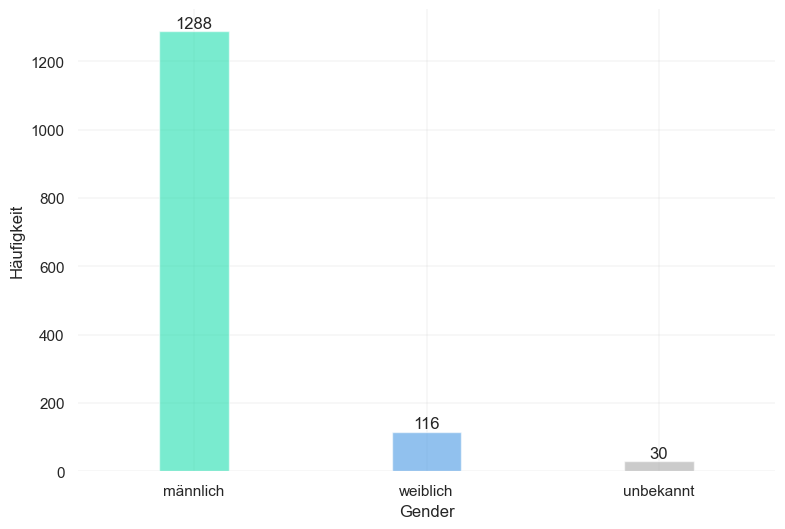

In [57]:
data_counts = df['Gender'].value_counts().reset_index()
data_counts.columns = ['Gender', 'Häufigkeit']
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")
ax=sns.barplot(data_counts, x="Gender", y="Häufigkeit", hue = "Gender", palette= ['#00FFBF', '#2E9AFE', 'darkgrey'], alpha=.6, width=0.3)
plt.ylabel("Häufigkeit")
plt.grid(True, linewidth=0.2)
for container in ax.containers:
    ax.bar_label(container) 
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

## 5. Ermittlung des Geburtsjahres und Sterbejahres

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-bottom: 20px; line-height: 1.8;">Wie bereits erwähnt, befinden sich die Angaben zum Geburtsdatum, Geburtsort sowie ggf. zum Sterbedatum und Sterbeort der Personen in der Spalte <b>Geburtsdatum,-ort/ggf. Sterbedatum,-ort</b>.  Die Geburts- und Sterbejahre sollten extrahiert und in zwei neue Spalten abgespeichert werden. Die Analyse der Spalteneinträge zeigte, dass in den meisten Fällen die Angaben zur Geburt der Person nach den Strings <b>b.</b> oder <b>geb.</b> und die Angaben zum Tod der Person nach solchen Strings wie <b>d.</b>, <b>gest.</b>, <b>g.</b>, <b>hinger.</b> oder <b>umgek.</b> vorkommen, wie beispielsweise hier: <i>b. Bucharest, Rum. 5 Oct. 1909, d. Bern 2 Mar. 1960</i>. Zuerst wurde mithilfe regulärer Ausdrücke der Text, der zwischen den geburts- und todbezogenen Strings steht (hier: <i>Bucharest, Rum. 5 Oct. 1909</i>), extrahiert und in der separaten Liste <b>geboren</b> abgespeichert. Falls kein todbezogener String vorkam, was relativ häufig der Fall war, da viele Personen zur Zeit der Verfassung des Lexikons noch lebten, wurde der gesamte nach dem geburtsbezogenen String stehende Text ebenfalls in die Liste <b>geboren</b> extrahiert. Danach wurde der nach dem todbezogenen String stehende Text (hier: <i>Bern 2 Mar. 1960</i>) in der Liste <b>gestorben</b> abgespeichert. Für die Ermittlung des Geburts- und Sterbejahres wurden ebenfalls mit regulären Ausdrücken aus den Listen <b>geboren</b> und <b>gestorben</b> vierstellige Zahlen, die entweder mit 18 oder mit 19 beginnen, extrahiert und in den Listen <b>Geburtsjahr</b> und <b>Sterbejahr</b> abgespeichert.</div>

In [60]:
datum = df["Geburtsdatum,-ort/ggf. Sterbedatum,-ort"].tolist() # Spalte mit Geburts-und Sterbejahren als Liste

In [61]:
print(datum[:20])

['geb. 29. Sept. 1915\xa0 Wien;\xa0', 'geb. 14. Febr. 1902\xa0 Nürnberg;\xa0', 'geb. 1. Nov. 1898\xa0 Nikolsburg/Mähren;\xa0', 'geb. 26. Juli 1905\xa0 Ludenberg b. Düsseldorf;\xa0', 'geb. 1. Mai 1925\xa0 Hannover;\xa0', 'geb. 9. Juli 1879\xa0 Wien,\xa0 gest. 2. Jan. 1960\xa0 Zürich;\xa0', 'geb. 2. Okt. 1927\xa0 Berlin;\xa0', 'geb. 12. Juni 1905\xa0 Pilsen/Böhmen;\xa0', 'geb. 23. Juni 1894\xa0 Czernowitz/Bukowina,\xa0 gest. 14. Nov. 1975\xa0 Jerusalem;\xa0', 'geb. 30. Juli 1895\xa0 Sommerfeld/Niederlausitz,\xa0 gest. 27. Apr. 1959\xa0 Berlin (Ost);\xa0', 'geb. 25. Nov. 1883\xa0 Steinweg b. Regensburg,\xa0 gest. 20. Okt. 1951\xa0 Kulmbach/Oberfr.;\xa0', 'k.A.', 'geb. 4. Jan. 1897;\xa0', 'geb. 13. Aug. 1892\xa0 Krefeld,\xa0 gest. 18. Febr. 1962\xa0 New York;\xa0', 'geb. 20. März 1878\xa0 Berlin,\xa0 gest. 20. Apr. 1949\xa0 New York;\xa0', 'geb. 17. Jan. 1898\xa0 Wampersdorf b. Mödling/Niederösterr.;\xa0', 'geb. 1898 (?),\xa0 gest. 1942\xa0 in GB;\xa0', 'geb. 24. Nov. 1878\xa0 Schaffa/Mähr

In [62]:
geboren = [] #neue Liste für Strings mit geburtsbezogener Informantion
regex_geboren = re.compile(r'(?:^geb\.|^b\.)\s+(.*?)(?:\bd\.|\bgest\.|\bg\.|\bgef\.|\bumgek\.|\bexecuted|\bdied|\bhinger\.|$)', re.DOTALL)
for satz in datum: # Extrakion der Strings, die zwischen geburts- und sterbebezogenen Strings oder nach geburtsbezogenen Strings stehen
     ergebnisse = regex_geboren.findall(satz)
     if ergebnisse:
         for extrakt in ergebnisse:
                 geboren.append(extrakt) #Abspeicherung der geburtsbezogenen Strings
     else:
        geboren.append("")

In [63]:
print(geboren[:20])

['29. Sept. 1915\xa0 Wien;\xa0', '14. Febr. 1902\xa0 Nürnberg;\xa0', '1. Nov. 1898\xa0 Nikolsburg/Mähren;\xa0', '26. Juli 1905\xa0 Ludenberg b. Düsseldorf;\xa0', '1. Mai 1925\xa0 Hannover;\xa0', '9. Juli 1879\xa0 Wien,\xa0 ', '2. Okt. 1927\xa0 Berlin;\xa0', '12. Juni 1905\xa0 Pilsen/Böhmen;\xa0', '23. Juni 1894\xa0 Czernowitz/Bukowina,\xa0 ', '30. Juli 1895\xa0 Sommerfeld/Niederlausitz,\xa0 ', '25. Nov. 1883\xa0 Steinweg b. Regensburg,\xa0 ', '', '4. Jan. 1897;\xa0', '13. Aug. 1892\xa0 Krefeld,\xa0 ', '20. März 1878\xa0 Berlin,\xa0 ', '17. Jan. 1898\xa0 Wampersdorf b. Mödling/Niederösterr.;\xa0', '1898 (?),\xa0 ', '24. Nov. 1878\xa0 Schaffa/Mähren,\xa0 ', '15. Aug. 1915\xa0 Hamburg;\xa0', '31. Aug. 1887\xa0 Bernberg/Saale,\xa0 ']


In [64]:
gestorben = [] #neue Liste für Strings mit sterbebezogener Informantion
regex_gestorben = re.compile(r'(?:\bgest\.|\bg\.|\bd\.|\bexecuted|\bgef\.|\bdied|\bhinger\.|\bgef\.|\bhinger\.)\s+(.*)', re.IGNORECASE)
for satz in datum: # Extraktion der Strings, die nach sterbebezognen Strings stehen
     ergebnisse = regex_gestorben.findall(satz)
     if ergebnisse:
         for extrakt in ergebnisse:
             gestorben.append(extrakt) #Abspeicherung der sterbebezogenen Strings
     else:
         gestorben.append("")

In [65]:
print(gestorben[:20])

['', '', '', '', '', '2. Jan. 1960\xa0 Zürich;\xa0', '', '', '14. Nov. 1975\xa0 Jerusalem;\xa0', '27. Apr. 1959\xa0 Berlin (Ost);\xa0', '20. Okt. 1951\xa0 Kulmbach/Oberfr.;\xa0', '', '', '18. Febr. 1962\xa0 New York;\xa0', '20. Apr. 1949\xa0 New York;\xa0', '', '1942\xa0 in GB;\xa0', '10. Dez. 1953\xa0 Wien;\xa0', '', '12. Febr. 1976\xa0 Tel Aviv;\xa0']


In [66]:
geburtsjahr = [] #neue Liste für Geburtsjahr
for jahr in geboren: #nach Geburtsjahr mit RegEx in Liste "geboren" suchen
    matches = re.findall(r"18[0-9][0-9]|19[0-9][0-9]", jahr) #Regex für die Suche nach Jahreszahlen
    geburtsjahr.append(matches)

In [67]:
print(geburtsjahr[715:750])

[['1895'], ['1898', '1897'], ['1912'], ['1891'], ['1905'], ['1893'], ['1869'], ['1896'], ['1905'], ['1902'], ['1901'], ['1903'], ['1900'], ['1887'], ['1898'], ['1899'], ['1871'], ['1923'], ['1914'], ['1900'], ['1899'], ['1870'], ['1885'], ['1886'], ['1922'], ['1907'], ['1906'], ['1911'], ['1885'], [], ['1870'], ['1891'], ['1888'], [], ['1920']]


In [68]:
sterbejahr = [] #neue Liste für "Sterbejahr"
for jahr in gestorben: #nach Sterbejahr mit RegEx in Liste "gestorben" suchen
    matches = re.findall(r"18[0-9][0-9]|19[0-9][0-9]", jahr) #Regex für die Suche nach Jahreszahlen
    sterbejahr.append(matches)

In [69]:
print(sterbejahr[:20])

[[], [], [], [], [], ['1960'], [], [], ['1975'], ['1959'], ['1951'], [], [], ['1962'], ['1949'], [], ['1942'], ['1953'], [], ['1976']]


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Die Kontrolle der Ergebnisse zeigte, dass in den Listen <b>geburtsjahr</b> und <b>sterbejahr</b> in manchen Fällen die Jahresangaben fehlen und in manchen Fällen nicht nur eine, sondern zwei Jahreszahlen vorkommen. Dies wurde zum einen dadurch verursacht, dass der todbezogene String nach der Jahreszahl stand, wie beispielsweise <i>1943 umgek. im Holocaust</i>. So wurden die Sterbejahre zusammen mit den Geburtsjahren in die Spalte Geburtsjahr extrahiert. Ein anderer Grund dafür waren zwei alternative Jahresangaben in den entsprechenden Zeilen, wie beispielsweise <i>b. Cologne 15 Mar. 1908 (Bohemia, 1906 [?])</i>.  
Im ersten Fall könnten die Sterbejahre manuell in die Spalte Sterbejahr übertragen werden. Im zweiten Fall kann man nach korrekten Geburts- und Sterbeangaben recherchiert und die Spalteneinträge entsprechend korrigiert. Doch in diesem Projekt werden die Mehrfachnennungen einfachheitshalber in fehlende Werte umgewandelt.</div>


In [71]:
Geburtsjahr = [element[0] if len(element) == 1 else '' for element in geburtsjahr]  #neue Liste für Geburtsjahre ohne Klammern 
#und ohne mehrmals vorkommenen Jahren

In [72]:
print(Geburtsjahr[715:750])

['1895', '', '1912', '1891', '1905', '1893', '1869', '1896', '1905', '1902', '1901', '1903', '1900', '1887', '1898', '1899', '1871', '1923', '1914', '1900', '1899', '1870', '1885', '1886', '1922', '1907', '1906', '1911', '1885', '', '1870', '1891', '1888', '', '1920']


In [73]:
Sterbejahr = [element[0] if len(element) == 1 else '' for element in sterbejahr] 

In [74]:
print(Sterbejahr[:20])

['', '', '', '', '', '1960', '', '', '1975', '1959', '1951', '', '', '1962', '1949', '', '1942', '1953', '', '1976']


In [75]:
df.insert(5, 'Geburtsjahr', Geburtsjahr) # Geburtsjahr zu Spalte

In [76]:
df.insert(6, 'Sterbejahr', Sterbejahr) #Sterbejahr zu Spalte

In [77]:
HTML(df.iloc[:10, 2:7].to_html(index=False))

Nachname,Vorname,Gender,Geburtsjahr,Sterbejahr
Abrahamowicz,Uriel,männlich,1915,
Abusch,Alexander,männlich,1902,
Ackermann,Manfred,männlich,1898,
Adam,Wilhelm,männlich,1905,
Adams,Ellen C.,weiblich,1925,
Adler,Friedrich Wolfgang,männlich,1879,1960
Adler,Gerson,männlich,1927,
Adler,Max Kurt,männlich,1905,
Adler-Rudel,Salomon,männlich,1894,1975
Adolph,Alfred,männlich,1895,1959


## 6. Ermittlung des Ausreisealters

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-bottom: 20px; line-height: 1.8;">Die standardisierten Angaben der Geburtsjahre ermöglichen die Ermittlung weiterer für die Untersuchung der Emigration und des Exils relevanten Werte  wie z. B. das Ausreisealter. Unter dem Ausreisealter versteht man das Alter der Person zum Zeitpunkt ihrer ersten Ausreise aus Deutschland, Österreich oder der Tschechoslowakei. Für die Ermittlung des Ausreisealters wurden aus den Werten der Spalte <b>Zieljahr1</b> (Jahr der ersten Ausreise) die Werte der Spalte <b>Geburtsjahr</b> abgezogen. Die Ergebnisse werden in der neuen Spalte <b>Ausreisealter</b> abgespeichert.</div>

In [80]:
Ausreisejahr = df["Zieljahr1"].tolist()  #Spalte Zieljahr1 (Jahr der ersten Ausreise) zu Liste
Geburtsjahr = df["Geburtsjahr"].tolist()   #Spalte Geburtsjahr zu Liste

In [81]:
datentypen = [type(wert) for wert in Ausreisejahr]
print(datentypen[:20])

[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


In [82]:
datentypen = [type(wert) for wert in Geburtsjahr] # Geburtsjahre sind als Strings abgespeichert
#und sollen zunächst in Floats umgewandelt werden
print(datentypen[:20])

[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [83]:
Geburtsjahr = [float(x) if x else np.nan for x in Geburtsjahr] # String zu Float
datentypen = [type(wert) for wert in Geburtsjahr]
print(datentypen[:20])

[<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>]


In [84]:
ergebnis = [] #neue Liste für Ausreisealter
for wert_a, wert_b in zip(Ausreisejahr, Geburtsjahr): #Aus dem Ausreisejahr das Geburtsjahr abziehen
     ergebnis.append(wert_a - wert_b)

In [85]:
print(ergebnis[:20])

[19.0, 31.0, 40.0, 28.0, 14.0, 56.0, 12.0, 33.0, 42.0, 38.0, 51.0, nan, nan, 47.0, 61.0, 40.0, 40.0, 61.0, 18.0, 51.0]


In [86]:
df.insert(7, 'Ausreisealter', ergebnis) # neue Spalte "Ausreisealter" hinzufügen

In [87]:
HTML(df.iloc[:10, 2:8].to_html(index=False))

Nachname,Vorname,Gender,Geburtsjahr,Sterbejahr,Ausreisealter
Abrahamowicz,Uriel,männlich,1915,,19.0
Abusch,Alexander,männlich,1902,,31.0
Ackermann,Manfred,männlich,1898,,40.0
Adam,Wilhelm,männlich,1905,,28.0
Adams,Ellen C.,weiblich,1925,,14.0
Adler,Friedrich Wolfgang,männlich,1879,1960,56.0
Adler,Gerson,männlich,1927,,12.0
Adler,Max Kurt,männlich,1905,,33.0
Adler-Rudel,Salomon,männlich,1894,1975,42.0
Adolph,Alfred,männlich,1895,1959,38.0


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Nun kann auch das Ausreisealter der Personen sowie die Häufigkeit der ersten Ausreisen pro Jahr visualisiert werden.</div>

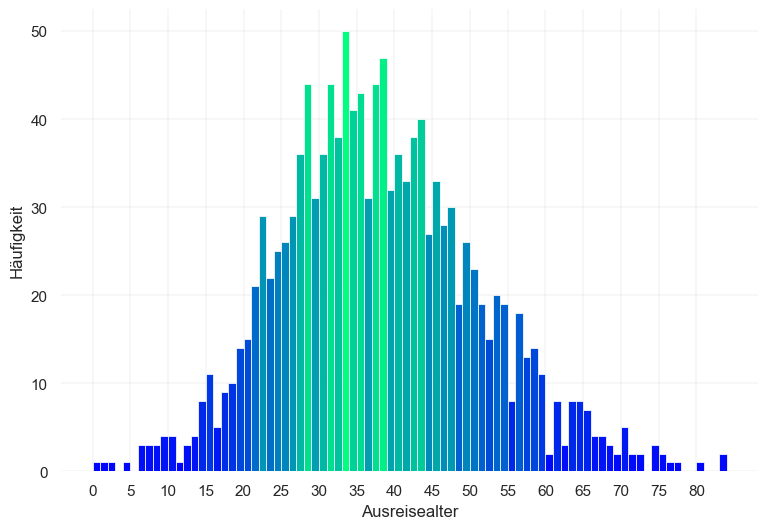

In [89]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 6))
ax = sns.histplot(data=df, x = "Ausreisealter", binwidth=1)
plt.grid(True, linewidth=0.2)
plt.ylabel("Häufigkeit")
plt.xticks(np.arange(df["Ausreisealter"].min(), df["Ausreisealter"].max()+1, 5))
for patch in ax.patches:
    height = patch.get_height()
    color = plt.cm.winter(height / max([p.get_height() for p in ax.patches]))
    patch.set_facecolor(color)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

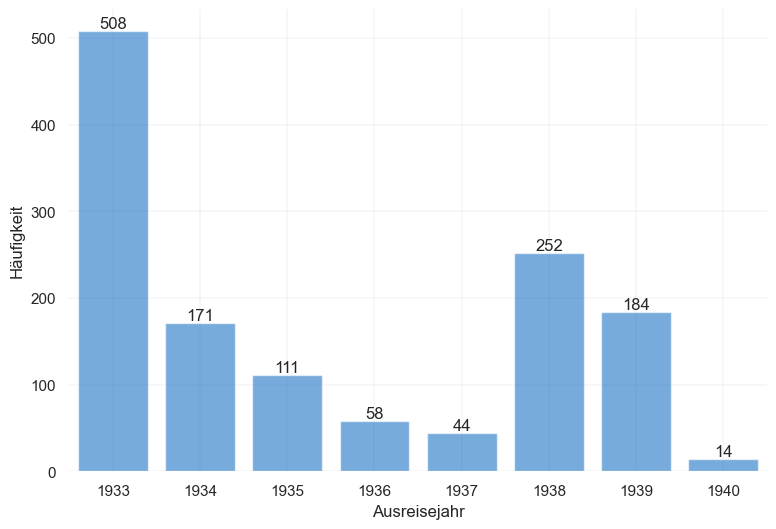

In [90]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 6))
year_counts = df['Zieljahr1'].value_counts().sort_index()
year_counts = year_counts[(year_counts.index >= 1933) & (year_counts.index <= 1940)]
df_year = pd.DataFrame({'Zieljahr1': year_counts.index, 'Index': year_counts.values})
df_year['Zieljahr1'] = df_year['Zieljahr1'].astype(int)
ax = sns.barplot(data=df_year, x= 'Zieljahr1', y = 'Index', alpha = 0.6, color = "#0174DF")
for container in ax.containers:
    ax.bar_label(container)
plt.grid(True, linewidth=0.2)
plt.xlabel("Ausreisejahr")
plt.ylabel("Häufigkeit") 
for spine in ax.spines.values():
    spine.set_visible(False)

## 7. Ermittlung der Anzahl der Zielorte

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-bottom: 20px; line-height: 1.8;">Ein weiterer für die Untersuchung der Emigration relevanter Wert ist <b>Anzahl der Zielorte</b>. Für die Ermittlung dieses Wertes wurden alle 14 <b>Zielort</b>-Spalten in einem neuen Data Frame <b>df_land</b> zusammengefügt. Die meisten Zeilen der Spalten sind nicht vollständig ausgefüllt, da nur relativ wenige Personen mehr als drei Mal die Zielländer gewechselt haben. Für die Ermittlung der Anzahl der Zielländer wurde zunächst die Anzahl der fehlenden Werte pro Zeile ermittelt. Danach wurde dieser Wert von der Gesamtanzahl der Spalten (also 14) abgezogen.</div> 

In [93]:
df_land = df[['Zielort1', 'Zielort2', 'Zielort3', 'Zielort4', 
              'Zielort5', 'Zielort6', 'Zielort7', 'Zielort8', 'Zielort9',
              'Zielort10', 'Zielort11', 'Zielort12', 'Zielort13', 'Zielort14']]

In [94]:
fehlende_werte = df_land.isnull() # Ermittlung der fehlenden und nicht fehlenden Werte
print(fehlende_werte[:5])

    Zielort1  Zielort2  Zielort3  Zielort4  Zielort5  Zielort6  Zielort7  \
12     False      True      True      True      True      True      True   
17     False     False     False     False     False      True      True   
20     False     False     False     False      True      True      True   
25     False     False     False     False      True      True      True   
26     False     False      True      True      True      True      True   

    Zielort8  Zielort9  Zielort10  Zielort11  Zielort12  Zielort13  Zielort14  
12      True      True       True       True       True       True       True  
17      True      True       True       True       True       True       True  
20      True      True       True       True       True       True       True  
25      True      True       True       True       True       True       True  
26      True      True       True       True       True       True       True  


In [95]:
anzahl_einträge = df_land.shape[1] - fehlende_werte.sum(axis=1) # Anzahl der Spalten minus Summe der fehlenden Werte
#pro Zeile
print(anzahl_einträge[:10])

12    1
17    5
20    4
25    4
26    2
42    4
43    1
58    1
63    2
65    7
dtype: int64


In [96]:
liste = anzahl_einträge.tolist()
df.insert(11, 'Anzahl_Zielorte', liste) # neue Spalte "Anzahl_Zielorte hinzufügen

In [97]:
HTML(df.iloc[:10, 11:25].to_html(index=False)) # neue Spalte "Anzahl_Zielorte hinzufügen

Anzahl_Zielorte,Zieljahr1,Zielort1,Zieljahr2,Zielort2,Zieljahr3,Zielort3,Zieljahr4,Zielort4,Zieljahr5,Zielort5,Zieljahr6,Zielort6,Zieljahr7
1,1934.0,Palestine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1933.0,Saarbrücken,1935.0,Prag,1937.0,France,1941.0,Mexiko,1946.0,Berlin,NaN,NaN,NaN
4,1938.0,Belgien,1938.0,Frankreich,1940.0,USA,1964.0,Österreich,NaN,NaN,NaN,NaN,NaN
4,1933.0,Saarbrücken,1933.0,France,1934.0,Denmark,1945.0,Berlin,NaN,NaN,NaN,NaN,NaN
2,1939.0,UK,1948.0,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1935.0,Belgien,1940.0,France,1940.0,USA,1946.0,CH,NaN,NaN,NaN,NaN,NaN
1,1939.0,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1938.0,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1936.0,UK,1949.0,Israel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1933.0,Prag,1933.0,Moskau,1933.0,NL,1933.0,France,1938.0,CH,1939.0,France,1946.0


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Zum Schluss erfolgt die Visualisierung der Verteilung des ermittelten Wertes <b>Anzahl Zielorte</b>.</div>

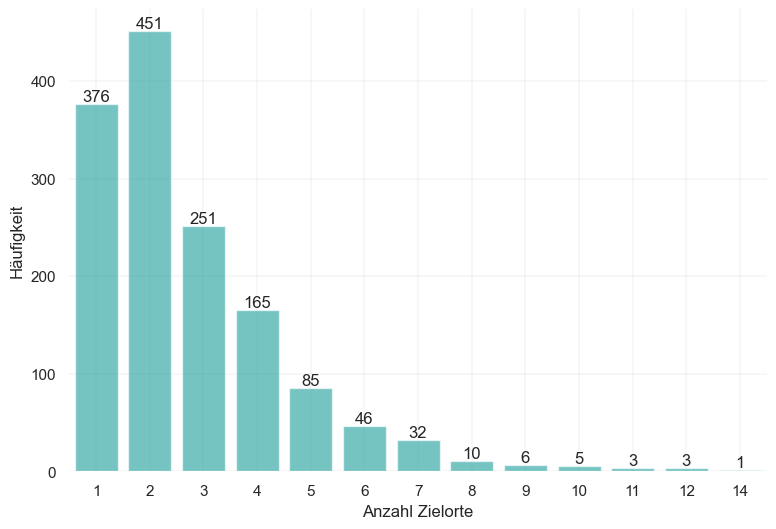

In [99]:
places_counts = df['Anzahl_Zielorte'].value_counts().sort_index()
df_places = pd.DataFrame({'Anzahl_Zielorte': places_counts.index, 'Index': places_counts.values})
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 6))
ax= sns.barplot(data=df_places, x= 'Anzahl_Zielorte', y = 'Index', alpha = 0.6, color = "#04B4AE")
for container in ax.containers:
    ax.bar_label(container) 
for spine in ax.spines.values():
    spine.set_visible(False)
plt.grid(True, linewidth=0.2)
plt.xlabel("Anzahl Zielorte")
plt.ylabel("Häufigkeit")
plt.show()

## 8. Standardisierung der Länder

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-bottom: 20px; line-height: 1.8;">Wie auch viele andere Angaben der Tabelle weisen die Zielortangaben, die in den Spalten Zielort1 bis Zielort14 enthalten sind, sprachliche Uneinheitlichkeit auf. Außerdem wurden manchmal vollständige Ländernamen, manchmal entsprechende Abkürzungen wie z.B. UK, CH oder USA und manchmal Stadtnamen eingetragen. Mit der Standardisierung der Zielländer-Spalten sollte erreicht werden, dass die Ländernamen standardisiert und Stadtnamen durch die entsprechenden, ebenfalls standardisierten Ländernamen ersetzt werden. Anschließend sollten alle Ländernamen in das Deutsche übersetzt werden. 
Die Standardisierung erfolge mithilfe der geographischen Datenbank <b>GeoNames</b> und des Python-Paket <b>requests</b>. Mit diesem Paket ist es möglich, Webseiten abzufragen. So werden die Angaben der Zielort-Spalten nacheinander in die Suchmaschine der Datenbank "geschickt". Danach ist es möglich, den HTML-Text der jeweiligen Ergebnisseiten automatsch zu durchsuchen. In diesem Projekt wird beispielsweise nur eine Spalte <b>Zieljahr1</b> standardisiert. Der Ergebnis der Abfrage der Datenbank ist eine Liste mit standardisierten Ländercode.</div>

In [102]:
HTML(df.iloc[:10, 12:26].to_html(index=False))

Zieljahr1,Zielort1,Zieljahr2,Zielort2,Zieljahr3,Zielort3,Zieljahr4,Zielort4,Zieljahr5,Zielort5,Zieljahr6,Zielort6,Zieljahr7,Zielort7
1934.0,Palestine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1933.0,Saarbrücken,1935.0,Prag,1937.0,France,1941.0,Mexiko,1946.0,Berlin,NaN,NaN,NaN,NaN
1938.0,Belgien,1938.0,Frankreich,1940.0,USA,1964.0,Österreich,NaN,NaN,NaN,NaN,NaN,NaN
1933.0,Saarbrücken,1933.0,France,1934.0,Denmark,1945.0,Berlin,NaN,NaN,NaN,NaN,NaN,NaN
1939.0,UK,1948.0,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1935.0,Belgien,1940.0,France,1940.0,USA,1946.0,CH,NaN,NaN,NaN,NaN,NaN,NaN
1939.0,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1938.0,UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1936.0,UK,1949.0,Israel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1933.0,Prag,1933.0,Moskau,1933.0,NL,1933.0,France,1938.0,CH,1939.0,France,1946.0,Deutschland


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-bottom: 20px; line-height: 1.8;">Wie man oben sieht, befindet sich zwischen den standardisierten Zielländern die Stadt <b>Saarbrücken</b>. Das Programm wird die Stadt dem Land <b>Deutschland</b> zuweisen, was aus der heutigen Perspektive auch korrekt ist. Jedoch wurde das Saargebiet und mit ihm auch die Stadt Saarbrücken nach dem Ersten Weltkrieg unter die Verwaltung des Völkerbundes gestellt. Erst 1935 wurde Saargebiet an das Deutsche Reich angegliedert. Dies wird im Coode entsprechend berücksichtigt.</div>

In [104]:
#Zielort = df["Zielort1"].tolist()  # Spalte "Zielort1" als Liste
#Zielort = list(map(str, Zielort))  # Liste als String-Liste

#datei_Ziel1 = open("Zielort1.txt", "w", encoding="utf-8")  # Öffnen der Datei für Abspeicherung der Ergebnisse
#country_list = []  # neue Liste für Länder-Codes

#for city in Zielort:
    # die Werte der Zeile werden nacheinander in die Suchseite der GeoNames-Datenbank geschickt
    #response = requests.request("GET", f"https://www.geonames.org/search.html?q={city}&country=")
    #ergebnis = re.findall(r"/countries.*\.html", response.text)  # auf der Ergebnis-Seite wird Spalte Countries gefunden
    
    #if city == "nan":
        #country_list.append("")
    #elif city == "Saarbrücken":
        #country_list.append("Saarbrücken")
    #elif ergebnis:
        # dem ersten Ergebnis in der Spalte Countries [0] wird ein ".html"-String abgetrennt
        # Danach wird der Länder-Code an der Stelle [-2] gefunden
        #country_code = ergebnis[0].strip(".html").split("/")[-2]
        #country_list.append(country_code)
    #else:
        #country_list.append("")

#for country in country_list:  # Länder-Coden werden in einer txt-Datei abgespeichert
    #datei_Ziel1.write(country)
    #datei_Ziel1.write("\n")

#datei_Ziel1.close() 

In [105]:
Zielland1 = open("Zielort1.txt", "r", encoding="utf-8").read().split("\n")[:-1]
print(Zielland1[:100])

['PS', 'Saarbrücken', 'BE', 'Saarbrücken', 'GB', 'BE', 'US', 'GB', 'GB', 'CZ', 'CZ', 'GB', 'GB', 'GB', 'FR', 'NO', 'GB', 'GB', 'PS', 'PS', 'FR', 'PL', 'DK', 'CZ', 'FR', 'RU', 'RU', 'PS', 'FR', 'SX', 'CZ', 'PS', 'GB', 'SX', 'FR', 'GB', 'PS', 'PS', 'GB', 'PS', 'PS', 'PS', 'TR', 'GB', 'GB', 'US', 'FR', 'PS', 'CZ', 'FR', 'RU', 'AR', 'CN', 'PS', 'SX', 'CZ', 'FR', 'PS', 'CZ', 'IT', 'LU', 'GB', 'IT', 'AT', 'BE', 'SE', 'RS', 'Saarbrücken', 'CZ', 'SX', 'SX', 'GB', 'GB', 'CZ', 'PS', 'CZ', 'GB', 'RU', 'AU', 'FR', 'SE', 'FR', 'PS', 'PS', 'PE', 'DK', 'RU', 'FR', 'GB', 'Saarbrücken', 'BE', 'PS', 'EC', 'IT', 'FR', 'CZ', 'US', 'ZA', 'PS', 'FR']


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Anschließend werden die standardisierten Ländercodes mithilfe der Dictionaries des Packets <b>GeonamesCache</b> in Ländernamen (auf Englisch) umgewandelt.</div>

In [107]:
gc = geonamescache.GeonamesCache() #mithilfe der Dictionaries werden vollständigen Namen der Länder ermittelt
countries = gc.get_countries()
country_names = []
for land_code in Zielland1:
    if land_code == "":
        country_names.append("")
    elif land_code == "Saarbrücken":
        country_names.append("Saarbrücken")
    elif land_code in countries:
        country_names.append(countries[land_code]['name'])
    else:
        country_names.append("")

In [108]:
land_namen=country_names

In [109]:
unique_liste = list(set(land_namen)) #unique Liste
unique_liste = list(map(str, unique_liste)) #unique Liste als String
unique_liste = [word for word in unique_liste if word != ''] #Entfernung fehlender Werte
print(unique_liste)

['Russia', 'Australia', 'New Zealand', 'Turkey', 'Netherlands', 'Colombia', 'United Kingdom', 'Paraguay', 'Sint Maarten', 'Austria', 'France', 'Argentina', 'Trinidad and Tobago', 'Denmark', 'Ecuador', 'United States', 'Poland', 'Latvia', 'South Africa', 'China', 'Italy', 'Finland', 'Canada', 'Bolivia', 'Mexico', 'Germany', 'Belgium', 'Luxembourg', 'Chile', 'Brazil', 'Norway', 'Saarbrücken', 'Peru', 'Sweden', 'Palestinian Territory', 'Spain', 'Czechia', 'Cuba', 'Kyrgyzstan', 'Egypt', 'Serbia', 'Hungary', 'Uruguay', 'Morocco']


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Die Untersuchung der Ergebnisse zeigt, dass die Datenbank <b>Geonames</b> die Abkürzung <b>NL</b> in der Spalte <b>Zielland1</b> nicht als <b>Netherlands</b> sondern als <b>Sint Maarten</b> interpretiert hat. Dies wird dann entsprechend korrigiert.</div>

In [111]:
unique_liste.remove("Sint Maarten") # Entfernung aus der unique liste
country_names = ["Netherlands" if city == "Sint Maarten" else city for city in country_names] # Ersetzung in der Ergebnisliste durch Netherlans

In [112]:
print(unique_liste)

['Russia', 'Australia', 'New Zealand', 'Turkey', 'Netherlands', 'Colombia', 'United Kingdom', 'Paraguay', 'Austria', 'France', 'Argentina', 'Trinidad and Tobago', 'Denmark', 'Ecuador', 'United States', 'Poland', 'Latvia', 'South Africa', 'China', 'Italy', 'Finland', 'Canada', 'Bolivia', 'Mexico', 'Germany', 'Belgium', 'Luxembourg', 'Chile', 'Brazil', 'Norway', 'Saarbrücken', 'Peru', 'Sweden', 'Palestinian Territory', 'Spain', 'Czechia', 'Cuba', 'Kyrgyzstan', 'Egypt', 'Serbia', 'Hungary', 'Uruguay', 'Morocco']


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Nun sollen die Koordinaten der Länder ermittelt werden, um eine Geovisualisirung der Daten zu ermöglichen. Die Koordinaten werden anhand der Koordinaten der Hauptstädte der jeweiligien Zielländer festgelegt. Die Hauptstädte der Länder werden über den bereits erwähnten Dictionary aus dem Paket <b>geonamescache</b> gefunden. Anschließend wurden mithilfe des Pakets <b>geopy</b> die Koordinaten der Städte ermittelt. Die Länder und deren Koordinaten wurden in einer neuen Excel-Tabelle <b>Koordinaten</b>  abgespeichert.</div> 

In [114]:
capitals = []  # neue Liste für Hauptstädte
gc = GeonamesCache()  # Ermittlung der Hauptstädte mithilfe der GeoName-Datenbank

for country in unique_liste:
    if country == "Saarbrücken":
        capitals.append("Saarbrücken")
    else:
        country_info = gc.get_countries_by_names().get(country)
        if country_info:
            capital = country_info.get("capital")
            capitals.append(capital)
        else:
            capitals.append("")

In [115]:
print(capitals)

['Moscow', 'Canberra', 'Wellington', 'Ankara', 'Amsterdam', 'Bogota', 'London', 'Asuncion', 'Vienna', 'Paris', 'Buenos Aires', 'Port of Spain', 'Copenhagen', 'Quito', 'Washington', 'Warsaw', 'Riga', 'Pretoria', 'Beijing', 'Rome', 'Helsinki', 'Ottawa', 'Sucre', 'Mexico City', 'Berlin', 'Brussels', 'Luxembourg', 'Santiago', 'Brasilia', 'Oslo', 'Saarbrücken', 'Lima', 'Stockholm', 'East Jerusalem', 'Madrid', 'Prague', 'Havana', 'Bishkek', 'Cairo', 'Belgrade', 'Budapest', 'Montevideo', 'Rabat']


In [116]:
capitals = ["Jerusalem" if capital == "East Jerusalem" else capital for capital in capitals]
print(capitals)

['Moscow', 'Canberra', 'Wellington', 'Ankara', 'Amsterdam', 'Bogota', 'London', 'Asuncion', 'Vienna', 'Paris', 'Buenos Aires', 'Port of Spain', 'Copenhagen', 'Quito', 'Washington', 'Warsaw', 'Riga', 'Pretoria', 'Beijing', 'Rome', 'Helsinki', 'Ottawa', 'Sucre', 'Mexico City', 'Berlin', 'Brussels', 'Luxembourg', 'Santiago', 'Brasilia', 'Oslo', 'Saarbrücken', 'Lima', 'Stockholm', 'Jerusalem', 'Madrid', 'Prague', 'Havana', 'Bishkek', 'Cairo', 'Belgrade', 'Budapest', 'Montevideo', 'Rabat']


In [117]:
df_koord = pd.DataFrame({'Land': unique_liste , 'Stadt': capitals})
print(df_koord[:20])

                   Land          Stadt
0                Russia         Moscow
1             Australia       Canberra
2           New Zealand     Wellington
3                Turkey         Ankara
4           Netherlands      Amsterdam
5              Colombia         Bogota
6        United Kingdom         London
7              Paraguay       Asuncion
8               Austria         Vienna
9                France          Paris
10            Argentina   Buenos Aires
11  Trinidad and Tobago  Port of Spain
12              Denmark     Copenhagen
13              Ecuador          Quito
14        United States     Washington
15               Poland         Warsaw
16               Latvia           Riga
17         South Africa       Pretoria
18                China        Beijing
19                Italy           Rome


In [118]:
#Capitals = df_koord["Stadt"].tolist() #Spalte Hauptstädte als Liste
#geolocator = Nominatim(user_agent="my_geocoder", timeout=10) #Ermittlung der Koordinaten der Hauptstädte mit Paket Nominatim
#lat = [] #neue Liste für Latitude
#lon = [] #neue Liste für Longitude
#for capital in Capitals:
    #location = geolocator.geocode(capital)
    #if location:
        #lat.append(location.latitude)
        #lon.append(location.longitude)
    #else:
        #lat.append('')
        #lon.append('')
#df_koord["lat"] = lat # Latitude-Spalte wird dem Data Frame "Koordinaten" hinzugefügt
#df_koord["lon"] = lon #Longitude wird dem Data Frame "Koordinaten" hinzugefügt 
#df_koord.to_excel("Koordinaten.xlsx")

In [119]:
df_koord=pd.read_excel("Koordinaten.xlsx")
print(df_koord[:20])

                     Land          Stadt        lat         lon
0     Trinidad and Tobago  Port of Spain  10.657268  -61.518017
1                 Denmark     Copenhagen  55.686724   12.570072
2                 Czechia         Prague  50.059629   14.446459
3                  Canada         Ottawa  45.420878  -75.690111
4          United Kingdom         London  51.489334   -0.144055
5                  Latvia           Riga  56.949398   24.105185
6                  Norway           Oslo  59.913330   10.738970
7                   China        Beijing  39.905714  116.391297
8                   Spain         Madrid  40.416705   -3.703582
9                 Austria         Vienna  48.208354   16.372504
10                 Brazil       Brasilia -10.333333  -53.200000
11                Uruguay     Montevideo -34.905892  -56.191310
12             Luxembourg     Luxembourg  49.611277    6.129799
13              Australia       Canberra -35.297591  149.101268
14            New Zealand     Wellington

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Im nächsten Schritt werden die Ländernamen in das Deutsche übersetzt. Da die automatischen Übersetzungen von großen Datenmengen sehr lange dauern, wurde auf die Übersetzung der gesamten Spalte verzichtet. Stattdessen wird die oben bereits erstellte <b>unique_liste</b>, die 42 einzigartige Ländernamen enthält, mithilfe des Pakets <b>translate</b> übersetzt und als Dictionary mit ursprünglichen englischen Ländernamen und entsprechenden deutschen Übersetzungen  abgespeichert. Danach wird mit dem Dictionary die gesamte <b>Zielland1</b>-Spalte übersetzt.</div>

In [121]:
#translator = Translator(to_lang="German") #Übersetzung der unique_liste ins Deutsche mit dem Paket Translator
#word_dict = {} #eues Wörterbuch für Länder auf Englisch und auf Deutsch

#for word in unique_liste:
    #translated_word = translator.translate(word)
    #word_dict[word] = translated_word #dem Dictionary werden die Ergebnisse der Übersetzung hinzugefügt
#with open('land_dict.txt', 'w') as file: # neue txt-Datei für Dictionary
    #for eng_word, de_word in word_dict.items():
        #file.write(f"{eng_word}\t{de_word}\n") # Abspeicherung der Dictionary

In [122]:
word_dict = {} #neuer Dictionary 
with open('land_dict.txt', 'r') as file:
    for line in file:
        eng_word, de_word = line.strip().split('\t')
        word_dict[eng_word] = de_word #dem Dictionary werden die englische und deutsche Wörter hinzugefügt
translated_words = [] #neue Liste für übersetzte Länder
for word in country_names: #Übersetzung der Spalte mit Dictionary
    if word in word_dict:
        translated_words.append(word_dict[word])
    else:
        translated_words.append("")

In [123]:
print(translated_words[:20])

['Palästina', 'Saarbrücken', 'Belgien', 'Saarbrücken', 'Vereinigtes Königreich', 'Belgien', 'Vereinigte Staaten', 'Vereinigtes Königreich', 'Vereinigtes Königreich', 'Tschechien', 'Tschechien', 'Vereinigtes Königreich', 'Vereinigtes Königreich', 'Vereinigtes Königreich', 'Frankreich', 'Norwegen', 'Vereinigtes Königreich', 'Vereinigtes Königreich', 'Palästina', 'Palästina']


In [124]:
Land=df_koord['Land'].tolist()
übersetzte_länder = [] #neue Liste für übersetzte Länder
for land in Land: #Übersetzung der Spalte mit Dictionary
    if land in word_dict:
        übersetzte_länder.append(word_dict[land])
    else:
        übersetzte_länder.append("")
print(übersetzte_länder)

['Trinidad und Tobago', 'Dänemark', 'Tschechien', 'Kanada', 'Vereinigtes Königreich', 'Lettland', 'Norwegen', 'China', 'Spanien', 'Österreich', 'Brasilien', 'Uruguay', 'Luxemburg', 'Australien', 'Neuseeland', 'Ungarn', 'Frankreich', 'Mexiko', 'Vereinigte Staaten', 'Palästina', 'Argentinien', 'Marokko', 'Belgien', 'Paraguay', 'Finnland', 'Ekuador', 'Saarbrücken', 'Kuba', 'Südafrika', 'Türkei', 'Kirgisistan', 'Deutschland', 'Polen', 'Chile', 'Kolumbien', 'Serbien', 'Ägypten', 'Peru', 'Bolivien', 'Schweden', 'Niederlande', 'Russland', 'Italien']


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Nach der Übersetzung der Spalte werden einige Korrekturen vorgenommen: Namen wie <i>Vereinigtes Königreich</i> oder <i>Vereinigte Staaten</i> werden abgekürzt, Länder wie <i>Russland</i> oder <i>Tschechien</i> werden in <i>Sowjet Union</i> und <i>Tschechoslowakei</i> umbenannt, um die historischen Veränderungen der politischen Grenzen zu berücksichtigen.</div>

In [126]:
ersetzungen = {
    "Vereinigtes Königreich": "UK",
    "Vereinigte Staaten": "USA",
    "Tschechien": "Tschechoslowakei",
    "Russland": "Sowjet Union"
}
translated_words = [ersetzungen.get(ort, ort) for ort in translated_words]
print(translated_words[:20])

['Palästina', 'Saarbrücken', 'Belgien', 'Saarbrücken', 'UK', 'Belgien', 'USA', 'UK', 'UK', 'Tschechoslowakei', 'Tschechoslowakei', 'UK', 'UK', 'UK', 'Frankreich', 'Norwegen', 'UK', 'UK', 'Palästina', 'Palästina']


In [127]:
übersetzte_länder = [ersetzungen.get(ort, ort) for ort in übersetzte_länder]

In [128]:
df_koord.insert(2, 'Land_german', übersetzte_länder)

In [129]:
print(df_koord[:10])

                  Land          Stadt          Land_german        lat  \
0  Trinidad and Tobago  Port of Spain  Trinidad und Tobago  10.657268   
1              Denmark     Copenhagen             Dänemark  55.686724   
2              Czechia         Prague     Tschechoslowakei  50.059629   
3               Canada         Ottawa               Kanada  45.420878   
4       United Kingdom         London                   UK  51.489334   
5               Latvia           Riga             Lettland  56.949398   
6               Norway           Oslo             Norwegen  59.913330   
7                China        Beijing                China  39.905714   
8                Spain         Madrid              Spanien  40.416705   
9              Austria         Vienna           Österreich  48.208354   

          lon  
0  -61.518017  
1   12.570072  
2   14.446459  
3  -75.690111  
4   -0.144055  
5   24.105185  
6   10.738970  
7  116.391297  
8   -3.703582  
9   16.372504  


In [130]:
df.insert(14, 'Zielland1_german', translated_words) # neue Spalte "Zielland1_german" hinzufügen

In [131]:
HTML(df.iloc[:20, 12:20].to_html(index=False))

Zieljahr1,Zielort1,Zielland1_german,Zieljahr2,Zielort2,Zieljahr3,Zielort3,Zieljahr4
1934.0,Palestine,Palästina,NaN,NaN,NaN,NaN,NaN
1933.0,Saarbrücken,Saarbrücken,1935.0,Prag,1937.0,France,1941.0
1938.0,Belgien,Belgien,1938.0,Frankreich,1940.0,USA,1964.0
1933.0,Saarbrücken,Saarbrücken,1933.0,France,1934.0,Denmark,1945.0
1939.0,UK,UK,1948.0,Canada,NaN,NaN,NaN
1935.0,Belgien,Belgien,1940.0,France,1940.0,USA,1946.0
1939.0,USA,USA,NaN,NaN,NaN,NaN,NaN
1938.0,UK,UK,NaN,NaN,NaN,NaN,NaN
1936.0,UK,UK,1949.0,Israel,NaN,NaN,NaN
1933.0,Prag,Tschechoslowakei,1933.0,Moskau,1933.0,NL,1933.0


<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">
Anschließend wurde die Spalte mit den standardisierten Ländernamen bei Berücksichtigung des Ausreisejahres visualisiert.<br>  
Mit <b>bar_polar</b>-Plot wird die Anreisehäufigkeit der 11 am meisten angereisten (mehr als 5 Anreisen) Zielländer im Jahr 1933 angezeigt. 
</div>

In [133]:
df_1933 = df[df['Zieljahr1'] == 1933]['Zielland1_german'].value_counts().reset_index() # Erstellung der Tabelle mit Einreisehäufigkeit 
#der einzelnen Zielländer im Jahr 1933 für Visualisierung mit bar_polar

In [134]:
df_1933.columns = ['Land_german', 'Anzahl_Einreisen']

In [135]:
print(df_1933[:10])

        Land_german  Anzahl_Einreisen
0  Tschechoslowakei               112
1        Frankreich                73
2             China                50
3       Saarbrücken                47
4       Niederlande                46
5         Palästina                41
6      Sowjet Union                39
7          Dänemark                24
8                UK                19
9        Österreich                18


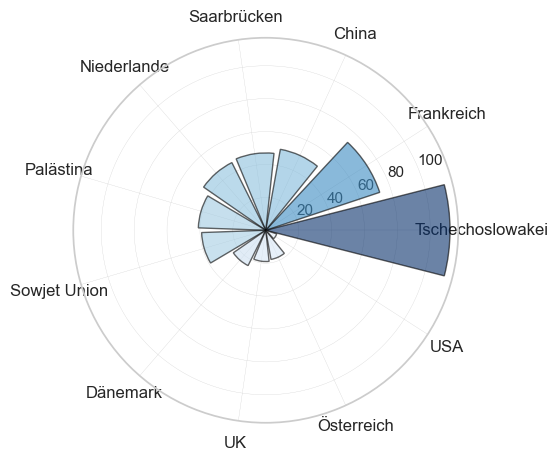

In [136]:
Land_german = df_1933["Land_german"][:11].tolist()
Werte= df_1933["Anzahl_Einreisen"][:11].tolist()
colors = plt.cm.Blues(np.array(Werte) / max(Werte))
angles = np.linspace(0, 2 * np.pi, len(Land_german), endpoint=False)
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
bars = ax.bar(angles, Werte, width=0.5, color=colors, edgecolor='black', alpha=0.6)
ax.set_xticks(angles)
ax.set_xticklabels(Land_german, fontsize=12)
ax.set_ylim(0, max(Werte) + 5)
plt.grid(True, linewidth=0.2)
plt.show()

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">
Mit <b>heatmap</b> wird die Häufigkeit der Einreisen pro Jahr angezeigt. Die Jahre mit wenigen Einreisen werden ausgeschlossen. Angezeigt werden nur die Länder mit 20 oder mehr Einreisen (bezogen auf alle Einreisejahre).
</div>

In [138]:
df_filtered = df[(df['Zieljahr1'] >= 1933) & (df['Zieljahr1'] <= 1939)] # Ausschluss der Jahre mit wenigen Einreisen
country_counts = df_filtered['Zielland1_german'].value_counts() # Ermittlung der Häufigkeit der Einreisen in einzelne Länder
countries_to_keep = country_counts[country_counts >= 20].index 
df_filtered = df_filtered[df_filtered['Zielland1_german'].isin(countries_to_keep)]# Ausschluss der Länder, die weniger als 20 mal eingereist wurden

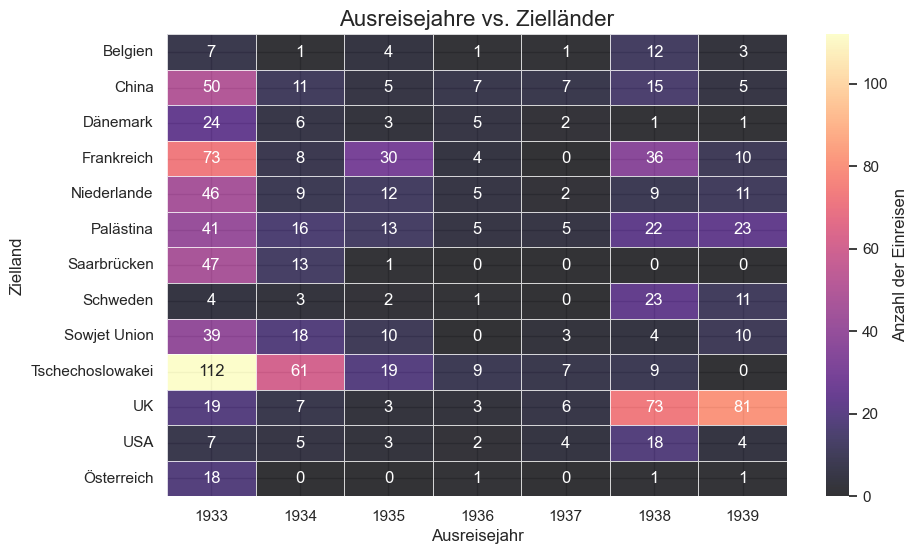

In [140]:
colors=["darkblue", "white", "darkred"]
custom_cmap = LinearSegmentedColormap.from_list("custom", colors)
df_filtered['Zieljahr1'] = df_filtered['Zieljahr1'].astype(int)
df_neu = df_filtered[["Zieljahr1", "Zielland1_german"]]
pivot = df_neu.pivot_table(index="Zielland1_german", columns="Zieljahr1", aggfunc="size", fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="magma", linewidths=0.5, alpha = 0.8, cbar_kws={'label': 'Anzahl der Einreisen'})

# Titel und Achsenbeschriftungen
plt.title("Ausreisejahre vs. Zielländer", fontsize=16)
plt.xlabel("Ausreisejahr", fontsize=12)
plt.ylabel("Zielland", fontsize=12)

plt.show()

<div style="font-family: 'Arial', sans-serif; font-size: 18px; padding-top: 20px; padding-bottom: 20px; line-height: 1.8;">Die <b>Geovisualisierung</b> der Daten mit <b>plotly</b> befindet sich auf der <a href="https://maja-ds.github.io/project01/data_cleaning.html" target="_blank"><b>HTML-Seite</b></a> des Projeks.</div>